In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect


In [6]:
engine = create_engine("sqlite:///Data/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Step 1: Climate Analysis and Exploration

In [11]:
# Preview tables, columns, and data types
inspector = inspect(engine)

for table_name in inspector.get_table_names():
    print(f'Table: {table_name}')
    print('-------------')
    for column in inspector.get_columns(table_name):
        print(f"Column: {column['name']}, {column['type']}")
    print('--------------------------------------')
    print('')

Table: measurement
-------------
Column: id, INTEGER
Column: station, TEXT
Column: date, TEXT
Column: prcp, FLOAT
Column: tobs, FLOAT
--------------------------------------

Table: station
-------------
Column: id, INTEGER
Column: station, TEXT
Column: name, TEXT
Column: latitude, FLOAT
Column: longitude, FLOAT
Column: elevation, FLOAT
--------------------------------------



## Import last year precipitation data into Pandas and plot

In [12]:
# Get date of last data point
last_date = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())

# Convert last date to datetime and subtract 1 year
first_date = dt.datetime.strptime(last_date, "('%Y-%m-%d',)") - dt.timedelta(days=366)

# Create query for pandas
pandas_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= first_date).\
    order_by(Measurement.date.asc()).all()

# Sum precipitation by date and set date as index
prec_df = pd.DataFrame(pandas_query).set_index(['date'])
prec_df = prec_df.rename(columns={'prcp':'Precipitation'})

prec_df.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


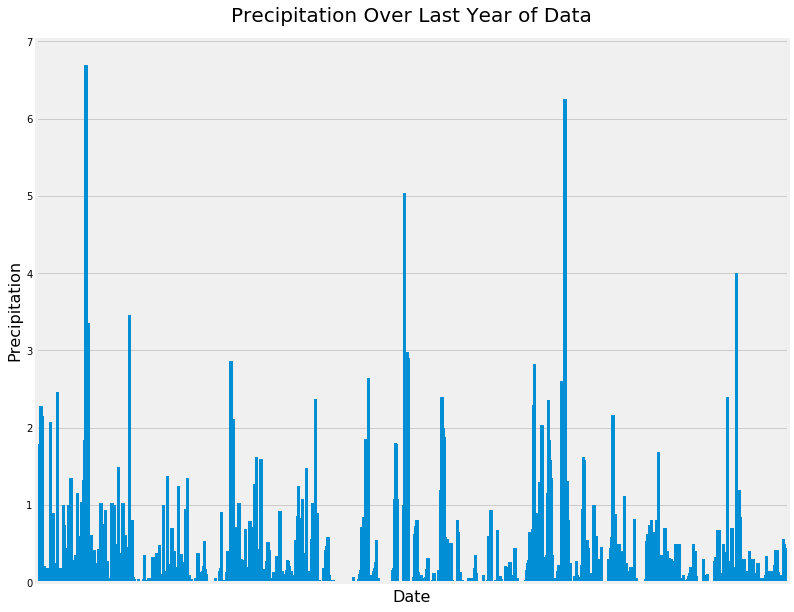

In [13]:
# Plot precipitation data
fig, ax1 = plt.subplots(figsize=(12,10))

prec_df.plot(kind='bar', ax=ax1, width=10)

ax1.grid(axis='x')
ax1.set_xticklabels([])
ax1.set_title('Precipitation Over Last Year of Data', size=20, y = 1.02, x = 0.5)
ax1.set_xlabel("Date", fontsize = 16)
ax1.set_ylabel("Precipitation", fontsize = 16)
ax1.get_legend().remove()

plt.show()

In [14]:
# Pandas summary statistics for the precipitation data
prec_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Import last year temperature data from the most active station into Pandas and plot

In [15]:
# Get total number of stations
session.query(Measurement).distinct(Measurement.station).\
    group_by(Measurement.station).count()

9

In [16]:
# List station activity in descending order (total row counts per station)
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Find lowest, highest, and average temperatures from the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter_by(station='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Return station with greatest number of temperature observations
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

('USC00519281', 2772)

In [19]:
# Create query for last 12 months of temperature data for station USC00519281
pandas_tobs_query = session.query(Measurement.tobs).\
    filter(Measurement.date >= first_date).\
    filter_by(station='USC00519281').all()

# Create dataframe using query
tobs_df = pd.DataFrame(pandas_tobs_query).rename(columns={'tobs':'Temperature'})

tobs_df

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


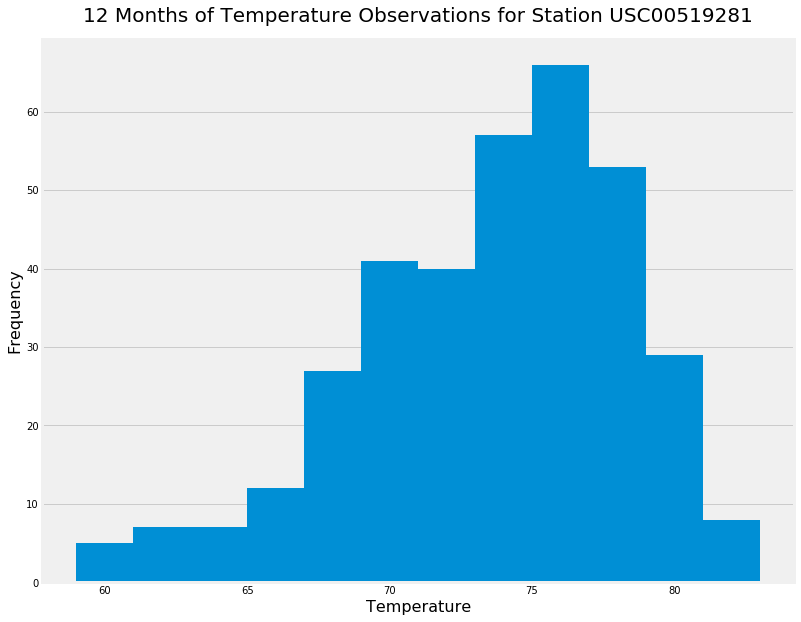

In [20]:
# Plot last 12 months of temperature data from most active temperature reading station
fig, ax1 = plt.subplots(figsize=(12,10))

tobs_df.plot(kind='hist', ax=ax1, bins=12)

ax1.grid(axis='x')
ax1.set_title('12 Months of Temperature Observations for Station USC00519281', size=20, y = 1.02, x = 0.5)
ax1.set_xlabel("Temperature", fontsize = 16)
ax1.set_ylabel("Frequency", fontsize = 16)
ax1.get_legend().remove()

plt.show()

# Bonus: Additional Analysis

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Import csv files into pandas
measure_df = pd.read_csv('Data/hawaii_measurements.csv')
stations_df = pd.read_csv('Data/hawaii_stations.csv')

## June vs. December Temperatures

In [49]:
# Convert date column to datetime
measure_df['date'] = pd.to_datetime(measure_df['date'])

# Create june and december dataframes
june_df = measure_df.loc[measure_df['date'].dt.month==6]
dec_df = measure_df.loc[measure_df['date'].dt.month==12]

# Calculate averages and display
june_temp_avg = round(june_df['tobs'].mean(), 1)
dec_temp_avg = round(dec_df['tobs'].mean(), 1)

print(f'''
    Average Temperatures:
    June: {june_temp_avg}
    December: {dec_temp_avg}
    ''')


    Average Temperatures:
    June: 74.9
    December: 71.0
    


In [61]:
import scipy.stats as stats
june_desc = stats.describe(june_df.tobs)
dec_desc = stats.describe(dec_df.tobs)
levene = stats.levene(june_df.tobs, dec_df.tobs)
ttest = stats.ttest_ind(june_df.tobs, dec_df.tobs, equal_var=False)

print(f'''
    June Temperature Stats Summary:
        {june_desc}
        
    December Temperature Stats Summary:
        {dec_desc}
        
    Levene test shows variances are not equal:
        {levene}
        
    Independent t-test assuming unequal variance, shows that the means are statistically different:
        {ttest}
    ''')


    June Temperature Stats Summary:
        DescribeResult(nobs=1700, minmax=(64, 85), mean=74.94411764705882, variance=10.610765848422947, skewness=-0.2258766702189613, kurtosis=-0.4229534222260054)
        
    December Temperature Stats Summary:
        DescribeResult(nobs=1517, minmax=(56, 83), mean=71.04152933421226, variance=14.031915337694345, skewness=-0.4050972954211533, kurtosis=0.45781715568357617)
        
    Levene test shows variances are not equal:
        LeveneResult(statistic=11.486485455366319, pvalue=0.0007094853311953783)
        
    Independent t-test assuming unequal variance, shows that the means are statistically different:
        Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)
    


* Unpaired (independent) t-test used due to Levene test showing unequal variances
    * Addtionally, there are not the same number of data points and the data can be from different stations
* The mean temperatures difference between June and December is statistically significant

## Temperature During Planned Trip
    * Trip is planned 2018-05-20 to 2018-05-30

In [62]:
# Based on input dates, displays minimum, average, and maximum temperatures
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [70]:
# Temperature stats during time of planned trip for the previous year
temp_trip_df = calc_temps('2017-05-20', '2017-05-30')
temp_trip_df

[(69.0, 75.23809523809524, 87.0)]

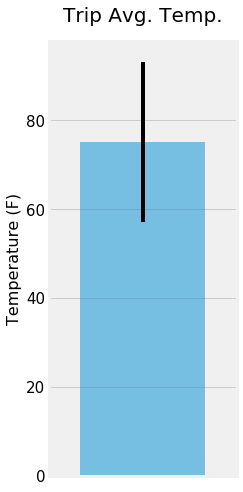

In [104]:
# Plot tempurature stats
fig, ax1 = plt.subplots(figsize=(3,8))

ax1.bar(0, temp_trip_df[0][1], yerr=temp_trip_df[0][2]-temp_trip_df[0][0], alpha=0.5)
ax1.set_xlim(-0.6, 0.6)
ax1.grid(axis='x')

# Labels
ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='both', labelsize=15)
ax1.set_title('Trip Avg. Temp.', size=20, y = 1.03) 
ax1.set_ylabel("Temperature (F)", fontsize = 16)

plt.show()

## Daily Rainfall Average
    * Analyse possible rainfall during planned trip dates

In [119]:
# Calculate the rainfall per weather station using the previous year's matching dates
trip_prcp = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= '2017-05-20').filter(Measurement.date <= '2017-05-30').\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

trip_prcp

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.29),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.25),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.5),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.2700000000000002),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.65),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.35000000000000003)]

In [133]:
def date_to_month_day(start, end):
    '''
    Args: 
        start/end: 'yyyy-mm-dd' format
    
    Returns:
        List of days in format 'mm-dd'
    '''
    
    day_list =[]
    start_date = dt.datetime.strptime(start, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end, "%Y-%m-%d")
    start_day = start_date.day
    
    while start_day <= end_date.day:
        day_list.append(f'{start_date.month}-{start_day}')
        start_day += 1
                        
    return day_list
    
date_to_month_day('2017-05-20','2017-05-30')

['5-20',
 '5-21',
 '5-22',
 '5-23',
 '5-24',
 '5-25',
 '5-26',
 '5-27',
 '5-28',
 '5-29',
 '5-30']

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


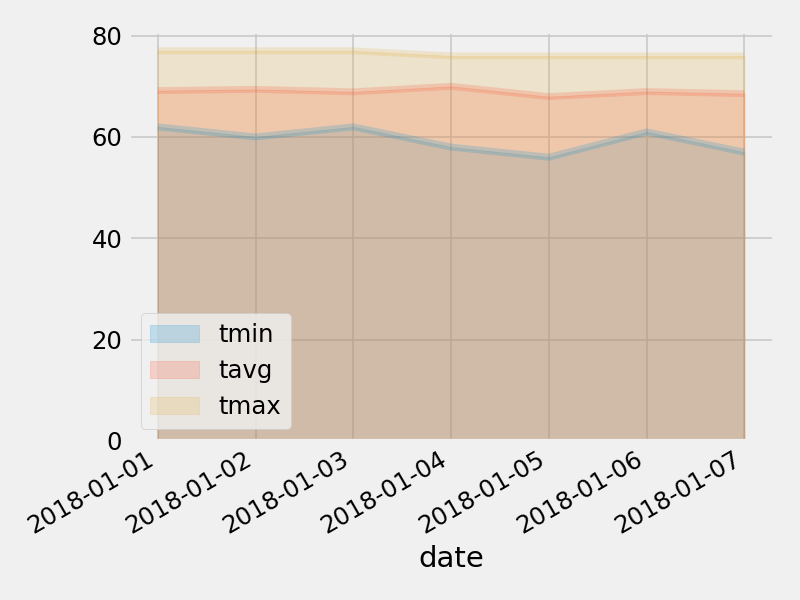

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
